# Emerging Market Concentration

Diego Alvarez: diego.alvarez@colorado.edu

# Packages

In [51]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Read Data

In [9]:
main_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(main_dir, "data")
em_dir = os.path.join(data_dir, "em_prices.parquet")

In [16]:
df_prices = (pd.read_parquet(
    path = em_dir, engine = "pyarrow").
    drop(columns = ["field"]).
    assign(ticker = lambda x: x.ticker.str.split(" ").str[0]).
    pivot(index = "date", columns = "ticker", values = "value").
    dropna())

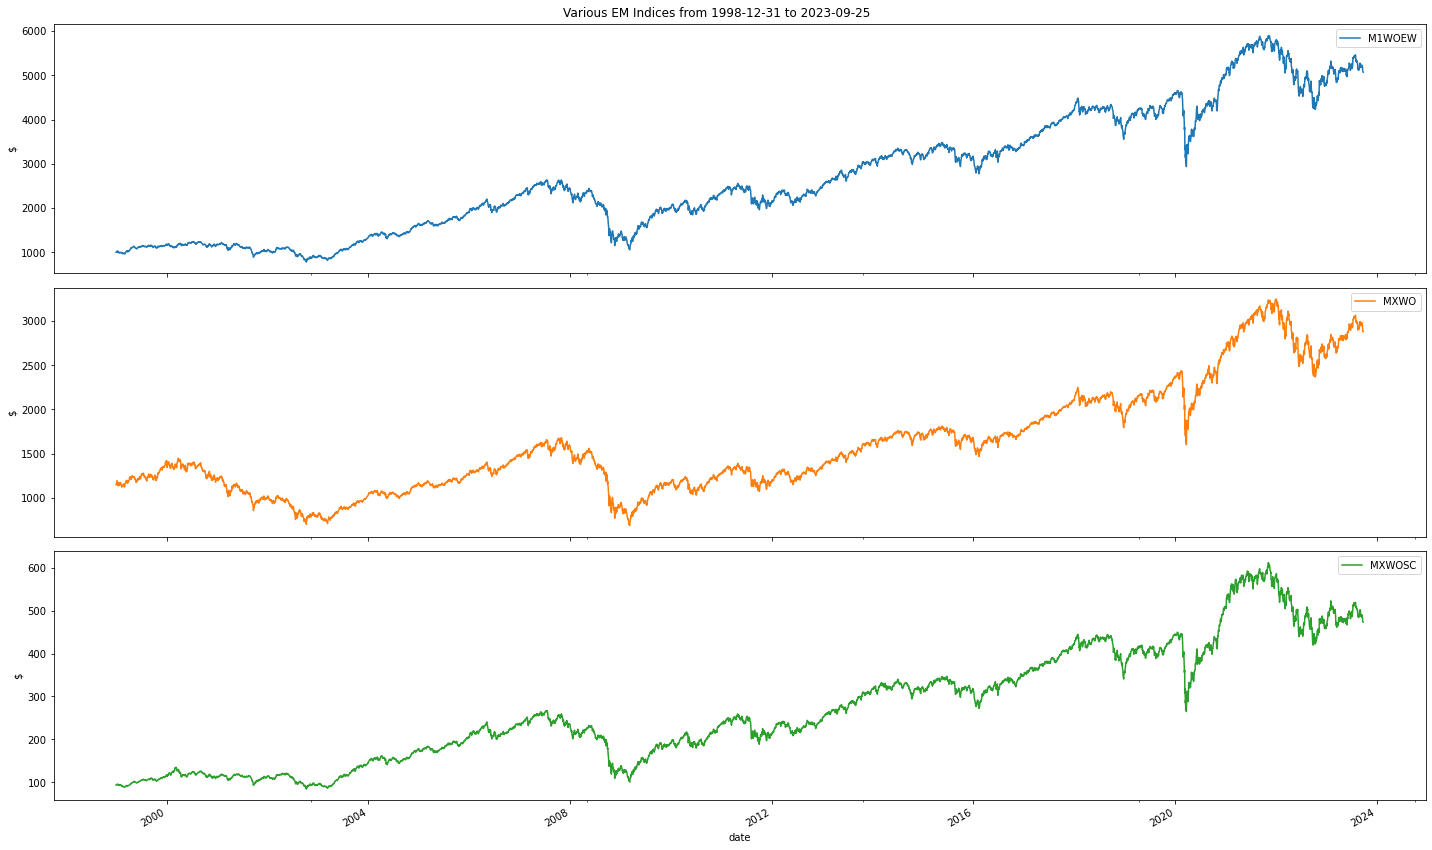

In [19]:
df_prices.plot(
    subplots = True,
    layout = (3,1),
    figsize = (20, 12),
    ylabel = "$",
    title = "Various EM Indices from {} to {}".format(
        df_prices.index.min().date(),
        df_prices.index.max().date()))

plt.tight_layout()
plt.show()

# Index Concentration Returns Differential

In [26]:
df_spread = (df_prices.pct_change(
    periods = 3 * 30).
    dropna().
    assign(
        spread_diff = lambda x: (x.MXWO - x.M1WOEW) * 100,
        z_score = lambda x: (x.spread_diff - x.spread_diff.rolling(window = 30 * 3).mean()) / x.spread_diff.rolling(window = 30 * 3).std())
    [["spread_diff", "z_score"]].
    dropna())

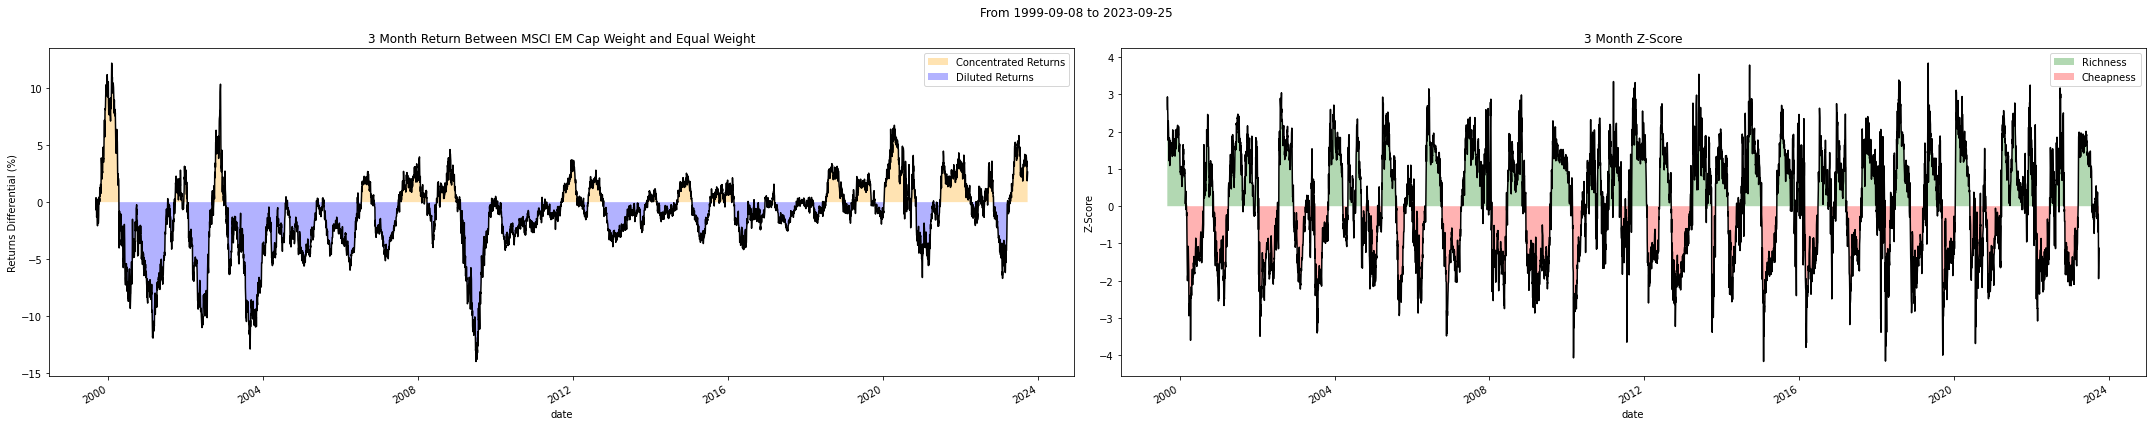

In [40]:
fig, axes = plt.subplots(ncols = 2, figsize = (30,6))

(df_spread[
    ["spread_diff"]].
    plot(
        ax = axes[0],
        ylabel = "Returns Differential (%)",
        color = "black",
        legend = False,
        title = "3 Month Return Between MSCI EM Cap Weight and Equal Weight"))

(df_spread[
    ["z_score"]].
    plot(
        ax = axes[1],
        ylabel = "Z-Score",
        color = "black",
        legend = False,
        title = "3 Month Z-Score"))

axes[0].fill_between(
    x = df_spread.index,
    y1 = df_spread.spread_diff,
    y2 = 0,
    where = df_spread.spread_diff > 0,
    facecolor = "orange",
    alpha = 0.3)

axes[0].fill_between(
    x = df_spread.index,
    y1 = df_spread.spread_diff,
    y2 = 0,
    where = df_spread.spread_diff < 0,
    facecolor = "blue",
    alpha = 0.3)

axes[1].fill_between(
    x = df_spread.index,
    y1 = df_spread.z_score,
    y2 = 0,
    where = df_spread.z_score > 0,
    facecolor = "green",
    alpha = 0.3)

axes[1].fill_between(
    x = df_spread.index,
    y1 = df_spread.z_score,
    y2 = 0,
    where = df_spread.z_score < 0,
    facecolor = "red",
    alpha = 0.3)

legend_elements1 = [
    Patch(facecolor = "orange", alpha = 0.3, label = "Concentrated Returns"),
    Patch(facecolor = "blue", alpha = 0.3, label = "Diluted Returns")]

legend_elements2 = [
    Patch(facecolor = "green", alpha = 0.3, label = "Richness"),
    Patch(facecolor = "red", alpha = 0.3, label = "Cheapness")]

axes[0].legend(handles = legend_elements1)
axes[1].legend(handles = legend_elements2)

fig.suptitle("From {} to {}".format(
    df_spread.index.min().date(),
    df_spread.index.max().date()))

plt.tight_layout()

# Regressing Returns agianst small caps

In [48]:
df_regress = (df_prices[
    ["MXWOSC"]].
    pct_change(periods = 3 * 30).
    dropna().
    assign(MXWOSC = lambda x: x.MXWOSC * 100).
    reset_index().
    merge(right = df_spread.reset_index(), how = "inner", on = ["date"]).
    set_index("date"))

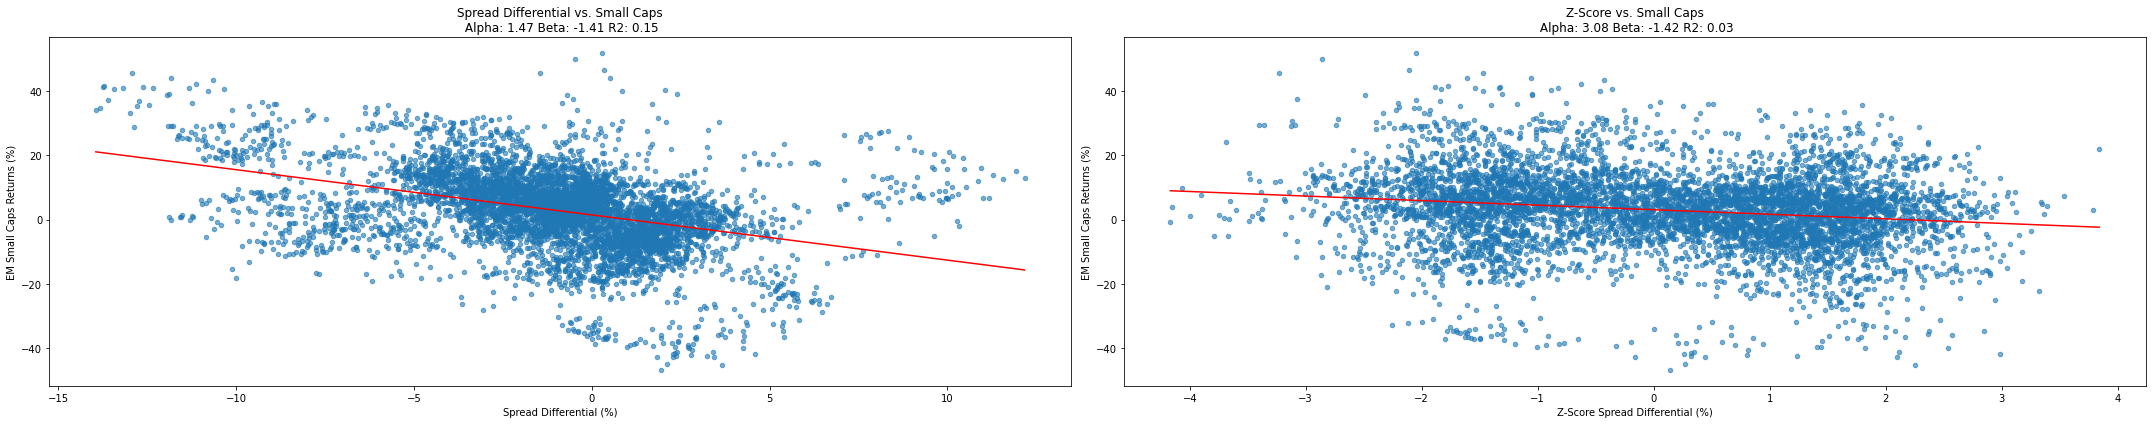

In [73]:
fig, axes = plt.subplots(ncols = 2, figsize = (30, 6))

regression1 = (sm.OLS(
    endog = df_regress.MXWOSC,
    exog = sm.add_constant(df_regress.spread_diff)).
    fit())

alpha1, beta1 = regression1.params
x1 = np.linspace(
    start = df_regress.spread_diff.min(),
    stop = df_regress.spread_diff.max(),
    num = 1_000)

y1 = (x1 * beta1) + alpha1

regression2 = (sm.OLS(
    endog = df_regress.MXWOSC,
    exog = sm.add_constant(df_regress.z_score)).
    fit())

alpha2, beta2 = regression2.params
x2 = np.linspace(
    start = df_regress.z_score.min(),
    stop = df_regress.z_score.max(),
    num = 1_000)

y2 = (x2 * beta2) + alpha2

(df_regress[
    ["spread_diff", "MXWOSC"]].
    plot(
        kind = "scatter", x = "spread_diff", y = "MXWOSC",
        alpha = 0.6,
        ax = axes[0],
        xlabel = "Spread Differential (%)",
        ylabel = "EM Small Caps Returns (%)",
        title = "Spread Differential vs. Small Caps\n Alpha: {} Beta: {} R2: {}".format(
            round(alpha1, 2),
            round(beta1, 2),
            round(regression1.rsquared, 2))))

axes[0].plot(x1,y1, color = "r")

(df_regress[
    ["z_score", "MXWOSC"]].
    plot(
        kind = "scatter", x = "z_score", y = "MXWOSC",
        alpha = 0.6,
        ax = axes[1],
        xlabel = "Z-Score Spread Differential (%)",
        ylabel = "EM Small Caps Returns (%)",
        title = "Z-Score vs. Small Caps\n Alpha: {} Beta: {} R2: {}".format(
            round(alpha2, 2),
            round(beta2, 2),
            round(regression2.rsquared, 2))))

axes[1].plot(x2,y2, color = "r")

plt.tight_layout()
plt.show()